In [1]:
import numpy as np
import matplotlib.pyplot as plt


from hnc import  HNC_solver
from qsps import *


In [2]:
# ri = QSP_HNC.rs_from_n(6.03e30*aB**3)
ri = 3
T = 1*eV#85.22*eV#104.25*eV#6.817*eV#104.25*eV
Te = T*eV 
Ti   = T*eV 
Z, A = 13, 27
Zstar= 3

    
qsp = QSP_HNC(Z, A, Zstar, Te, Ti, ri)

N_species = 1
# Gamma = np.array(  [[qsp.Γii, qsp.Γei, qsp.Γei ],
#                     [qsp.Γei, qsp.Γee, qsp.Γee],
#                     [qsp.Γei, qsp.Γee, qsp.Γee]])
Gamma = np.array([[qsp.Γee]])

names = ["Al", "e- up", "e- down"] 
kappa = 1
rho = np.array([  Zstar*3/(4*np.pi)])
hnc1 = HNC_solver(N_species, Gamma=Gamma, kappa=kappa, tol=1e-8,
                 kappa_multiscale=1, rho = rho, num_iterations=int(1e3), 
                 R_max=10, N_bins=1000, names=names, dst_type=3)
print("t=", qsp.Te/(qsp.E_F))

Λee = 0.314
Λei = 0.222
Γii=2221.152, Γie=-2.792, Γee=0.931 
r_i=3.000
r_e=2.080
t= 0.0031733145514768937


In [3]:
T = qsp.Te_c

In [4]:
from atomic_forces.atomOFDFT.python.physics import ThomasFermi
from scipy.optimize import root

def find_η(Te, ne):
    """
    Gets chemical potential in [AU] that gives density ne at temperature Te
    """
    f_to_min = lambda η: ThomasFermi.n_TF(Te, η)-ne # η = βμ in ideal gas, no potential case
    
    root_and_info = root(f_to_min, 0.4,tol=1e-4)

    η = root_and_info['x'][0]
    return η

def h_ee_ID(ne, T, r, η):
    sin_arg = np.sqrt(2*T*m_e)*r
    t_max = np.max([1/sin_arg, η ])
    
    
    t = np.linspace(0,t_max, num=10000) 
    dt = t[1]-t[0]
    κ = 3*(2*T*m_e) / (qsp.k_F**3 * r)  * np.sum(dt* t*np.sin(sin_arg*t) /(1+np.exp(t**2-η) )  )
    h_ee = -0.5*κ**2
    return h_ee
    

η = find_η(T, qsp.ne )
h_ee_ID_explicit = np.array([h_ee_ID(qsp.ne, T, r*qsp.ri, η ) for r in hnc1.r_array])

ModuleNotFoundError: No module named 'atoMEC'


/tmp/ipykernel_42832/1710663544.py:22: RuntimeWarning: overflow encountered in exp
  κ = 3*(2*T*m_e) / (qsp.k_F**3 * r)  * np.sum(dt* t*np.sin(sin_arg*t) /(1+np.exp(t**2-η) )  )


In [5]:
np.sqrt(2*T*m_e), hnc1.k_array/qsp.re

(0.846431861701338,
 array([7.55160109e-02, 2.26548033e-01, 3.77580055e-01, 5.28612076e-01,
        6.79644098e-01, 8.30676120e-01, 9.81708142e-01, 1.13274016e+00,
        1.28377219e+00, 1.43480421e+00, 1.58583623e+00, 1.73686825e+00,
        1.88790027e+00, 2.03893229e+00, 2.18996432e+00, 2.34099634e+00,
        2.49202836e+00, 2.64306038e+00, 2.79409240e+00, 2.94512443e+00,
        3.09615645e+00, 3.24718847e+00, 3.39822049e+00, 3.54925251e+00,
        3.70028453e+00, 3.85131656e+00, 4.00234858e+00, 4.15338060e+00,
        4.30441262e+00, 4.45544464e+00, 4.60647667e+00, 4.75750869e+00,
        4.90854071e+00, 5.05957273e+00, 5.21060475e+00, 5.36163677e+00,
        5.51266880e+00, 5.66370082e+00, 5.81473284e+00, 5.96576486e+00,
        6.11679688e+00, 6.26782891e+00, 6.41886093e+00, 6.56989295e+00,
        6.72092497e+00, 6.87195699e+00, 7.02298901e+00, 7.17402104e+00,
        7.32505306e+00, 7.47608508e+00, 7.62711710e+00, 7.77814912e+00,
        7.92918115e+00, 8.08021317e+00, 8.23

In [6]:
t = np.linspace(0,1000, num=10000) 
k = np.linspace(0,1000, num=10000)
dt = t[1]-t[0]
dk = k[1]-k[0]
print("ne==", 2*4*π * (2*m_e*T)**(3/2) /(2*π)**3 * np.sum( dt* t**2 /(1+np.exp( t**2-η) )  ) )
print("ne==", 2*4*π /(2*π)**3 * np.sum( dk* k**2 /(1+np.exp( 1/(2*T*m_e)* k**2-η)) ) ) 
print("ne_TF == ", ThomasFermi.n_TF(T, η))

ne== 0.026525821610769135
ne== 0.02652582161076913
ne_TF ==  0.026525823839201223


/tmp/ipykernel_42832/1553657529.py:5: RuntimeWarning: overflow encountered in exp
  print("ne==", 2*4*π * (2*m_e*T)**(3/2) /(2*π)**3 * np.sum( dt* t**2 /(1+np.exp( t**2-η) )  ) )
/tmp/ipykernel_42832/1553657529.py:6: RuntimeWarning: overflow encountered in exp
  print("ne==", 2*4*π /(2*π)**3 * np.sum( dk* k**2 /(1+np.exp( 1/(2*T*m_e)* k**2-η)) ) )


In [7]:
f_of_k = 1/(  1+np.exp((hnc1.k_array/qsp.ri)**2/(2*m_e*T) - η) )

/tmp/ipykernel_42832/648048246.py:1: RuntimeWarning: overflow encountered in exp
  f_of_k = 1/(  1+np.exp((hnc1.k_array/qsp.ri)**2/(2*m_e*T) - η) )


(0.0, 2.0)

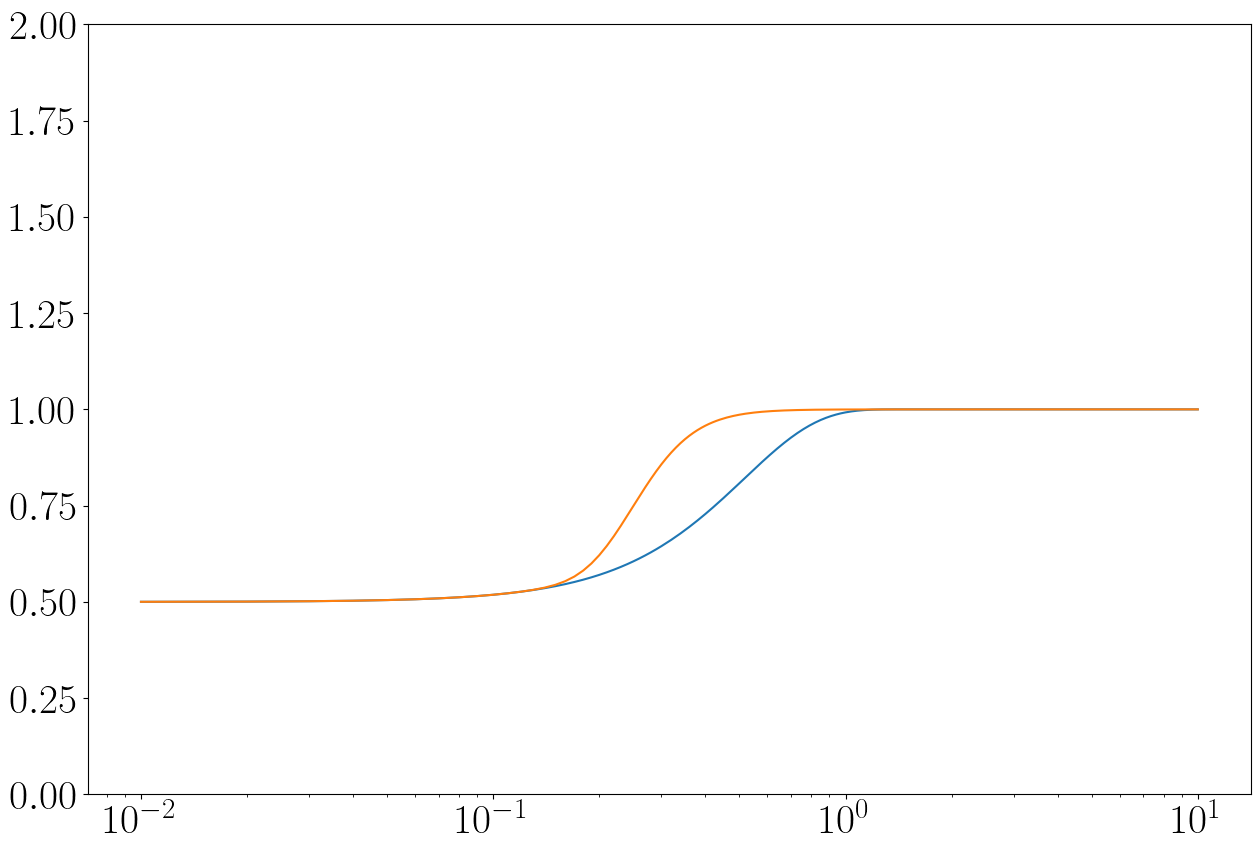

In [8]:
fig, ax = plt.subplots()

h_ee_ID_DST = -0.5* qsp.ri**-6*hnc1.FT_k_2_r(f_of_k)**2/(0.5*qsp.ne)**2
ax.plot(hnc1.r_array, h_ee_ID_DST +1)
ax.plot(hnc1.r_array, h_ee_ID_explicit+1)
ax.set_xscale('log')
ax.set_ylim(0,2)

# Invert HNC

In [9]:
def get_β_cP(h_r): #Pauli potential
    h_k = hnc1.FT_r_2_k(h_r)

    I_plus_h_rho_inverse = 1/(1 + h_k*hnc1.rho[0])
    c_k = I_plus_h_rho_inverse * h_k
    c_r = hnc1.FT_k_2_r(c_k)

    # Approximate with HNC
    β_cP   = h_r - c_r -np.log(h_r+1)
    return β_cP

β_cP_DST = get_β_cP(h_ee_ID_DST)
β_cP_explicit = get_β_cP(h_ee_ID_explicit)

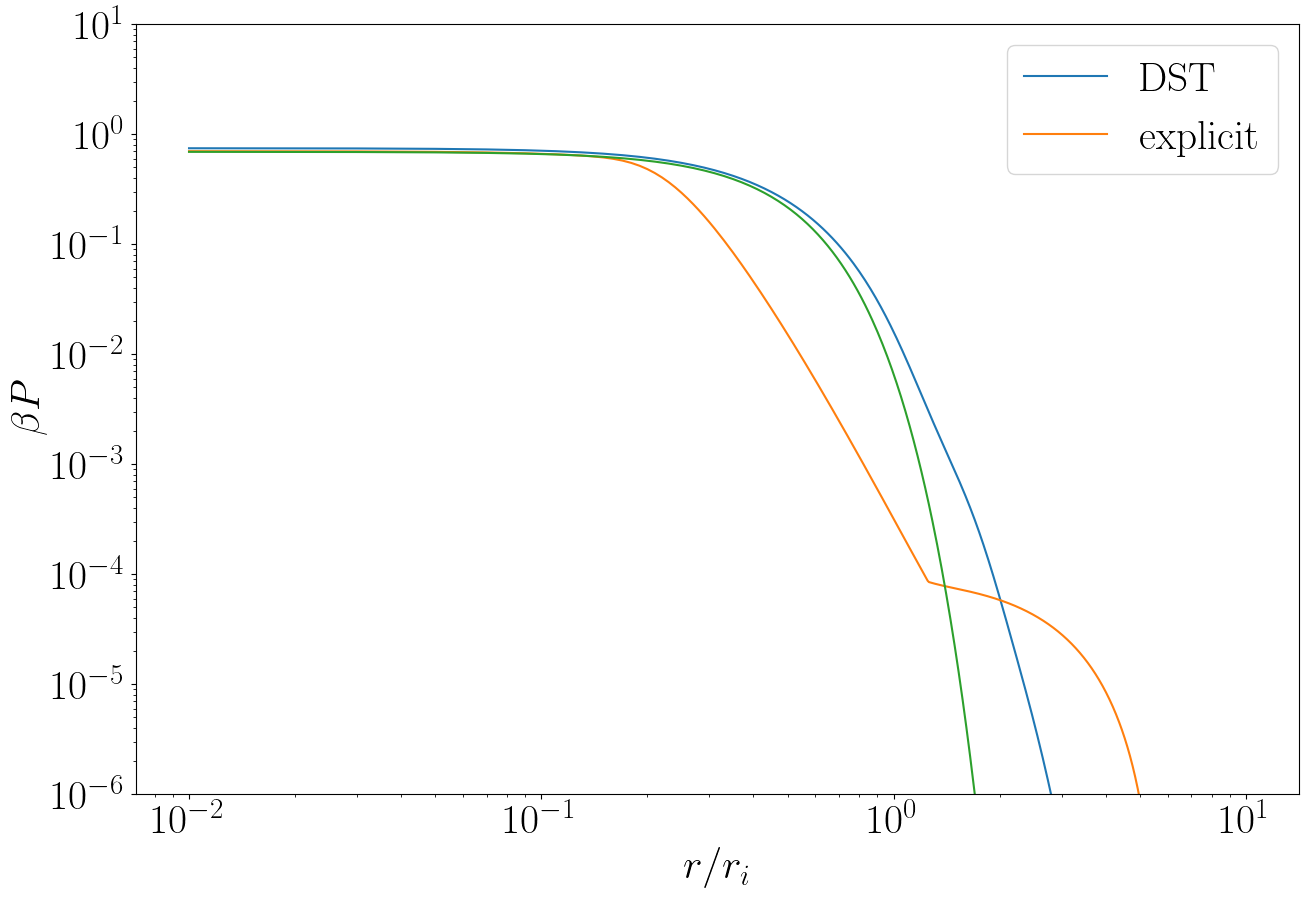

In [10]:
fig, ax = plt.subplots()

ax.plot(hnc1.r_array, β_cP_DST, label='DST')
ax.plot(hnc1.r_array, β_cP_explicit,label='explicit')
ax.plot(hnc1.r_array, qsp.βv_Pauli(hnc1.r_array, qsp.Λee))
ax.set_yscale('log')
ax.set_xscale('log')

ax.set_ylim(1e-6,1e1)
ax.set_ylabel(r'$\beta P$')
ax.set_xlabel(r'$r/r_i$')
ax.legend()

In [11]:
from scipy.special import erfc

def Slater_S(Γ):
    ymax = 100
    ymin = 0.01*π*np.sqrt(Γ*qsp.re)
    N = int(ymax/ymin)
    print(N)
    y = np.linspace(0,1e2,num=N)
    dy = y[1]-y[0]
    return -4* np.sqrt(π*Γ*qsp.re) * np.sum(dy* np.exp(-y**2)*y/(1 - np.exp(π*np.sqrt(Γ*qsp.re)/y )  ) )

def β_cΔ(Γ, x): 
    """
    x=r/r_e   
    """
    a = np.sqrt(qsp.re/Γ)
    γ = -np.sqrt(π*Γ*qsp.re)/np.log(Slater_S(Γ))
#     return Γ/x*( 1 - np.exp(-a**2*x**2) + np.sqrt(π)*a*x *erfc(a*x))
    return Γ/x*( 1 - np.exp(-a**2*x**2) + np.sqrt(π)*a*x/γ *erfc(γ*a*x))
    
def Γc():
    Γ = 1/(qsp.Te*qsp.re)
    ωp = np.sqrt(4*π*qsp.ne/m_e)
    return 2*Γ*qsp.Te * np.tanh(ωp/(2*qsp.Te))/( ωp  )

1710


/tmp/ipykernel_42832/3922971775.py:10: RuntimeWarning: divide by zero encountered in divide
  return -4* np.sqrt(π*Γ*qsp.re) * np.sum(dy* np.exp(-y**2)*y/(1 - np.exp(π*np.sqrt(Γ*qsp.re)/y )  ) )


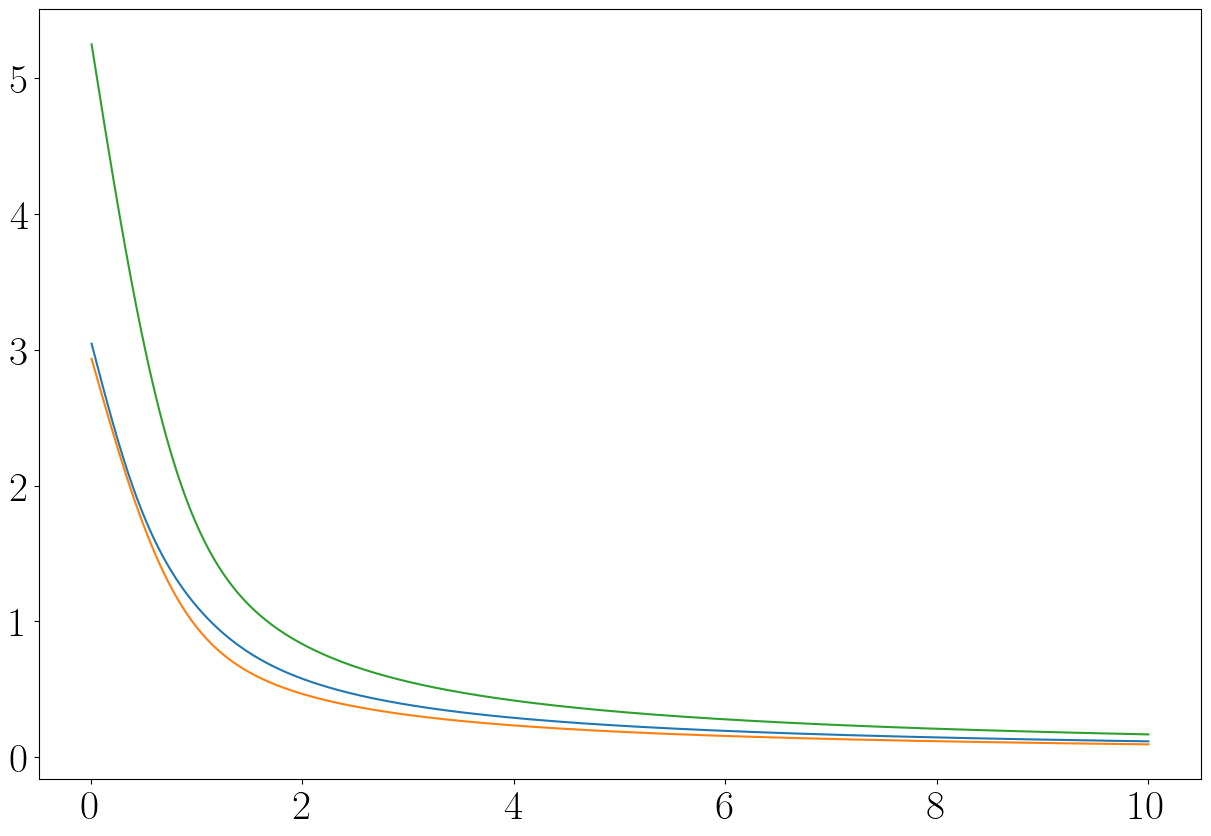

In [12]:
fig, ax = plt.subplots()



ax.plot(hnc1.r_array, β_cΔ(Γc(), hnc1.r_array*qsp.ri/qsp.re ))
ax.plot(hnc1.r_array, qsp.βv_Kelbg(qsp.Γee, hnc1.r_array, qsp.Λee))
ax.plot(hnc1.r_array, qsp.βv_Kelbg(Γc(), hnc1.r_array, qsp.Λee))

In [20]:
np.savetxt("βvee.txt",np.array([hnc1.r_array, β_cP_DST + β_cΔ(Γc(), hnc1.r_array*qsp.ri/qsp.re )]).T)

1710


/tmp/ipykernel_42832/3922971775.py:10: RuntimeWarning: divide by zero encountered in divide
  return -4* np.sqrt(π*Γ*qsp.re) * np.sum(dy* np.exp(-y**2)*y/(1 - np.exp(π*np.sqrt(Γ*qsp.re)/y )  ) )


In [13]:
βu_r_matrix = np.array([[β_cP_DST + β_cΔ(Γc(), hnc1.r_array*qsp.ri/qsp.re ) ]])

hnc1.set_βu_matrix(βu_r_matrix)
hnc1.initialize_c_k()
hnc1.set_C_matrix()
hnc1.HNC_solve(alpha_method='best', alpha_Picard = 1e-2, alpha_oz = 1e-4, h_max=1e4)
h_r_DST = hnc1.h_r_matrix[0,0]

βu_r_matrix = np.array([[β_cP_explicit + β_cΔ(Γc(), hnc1.r_array*qsp.ri/qsp.re ) ]])

hnc1.set_βu_matrix(βu_r_matrix)
hnc1.initialize_c_k()
hnc1.set_C_matrix()
hnc1.HNC_solve(alpha_method='best', alpha_Picard = 1e-2, alpha_oz = 1e-4, h_max=1e4)
h_r_explicit = hnc1.h_r_matrix[0,0]

1710
 HNC min: [0.5] True Optimization terminated successfully.
0: Err in c_r: 7.19e-02, OZ: 1.01e-01, HNC: 1.88e-02
 HNC min: [0.5] True Optimization terminated successfully.
1: Err in c_r: 4.28e-02, OZ: 1.04e-01, HNC: 9.86e-03
 HNC min: [0.5] True Optimization terminated successfully.
2: Err in c_r: 2.55e-02, OZ: 1.06e-01, HNC: 5.58e-03
 HNC min: [0.5] True Optimization terminated successfully.
3: Err in c_r: 1.53e-02, OZ: 1.07e-01, HNC: 3.30e-03
 HNC min: [0.5] True Optimization terminated successfully.
4: Err in c_r: 9.24e-03, OZ: 1.08e-01, HNC: 2.00e-03
 HNC min: [0.5] True Optimization terminated successfully.
5: Err in c_r: 5.63e-03, OZ: 1.08e-01, HNC: 1.24e-03
 HNC min: [0.5] True Optimization terminated successfully.
6: Err in c_r: 3.45e-03, OZ: 1.08e-01, HNC: 7.72e-04
 HNC min: [0.5] True Optimization terminated successfully.
7: Err in c_r: 2.13e-03, OZ: 1.09e-01, HNC: 4.87e-04


/tmp/ipykernel_42832/3922971775.py:10: RuntimeWarning: divide by zero encountered in divide
  return -4* np.sqrt(π*Γ*qsp.re) * np.sum(dy* np.exp(-y**2)*y/(1 - np.exp(π*np.sqrt(Γ*qsp.re)/y )  ) )


 HNC min: [0.5] True Optimization terminated successfully.
8: Err in c_r: 1.33e-03, OZ: 1.09e-01, HNC: 3.09e-04
 HNC min: [0.5] True Optimization terminated successfully.
9: Err in c_r: 8.34e-04, OZ: 1.09e-01, HNC: 1.97e-04
 HNC min: [0.5] True Optimization terminated successfully.
10: Err in c_r: 5.25e-04, OZ: 1.09e-01, HNC: 1.26e-04
 HNC min: [0.5] True Optimization terminated successfully.
11: Err in c_r: 3.33e-04, OZ: 1.09e-01, HNC: 8.06e-05
 HNC min: [0.5] True Optimization terminated successfully.
12: Err in c_r: 2.11e-04, OZ: 1.09e-01, HNC: 5.17e-05
 HNC min: [0.5] True Optimization terminated successfully.
13: Err in c_r: 1.35e-04, OZ: 1.09e-01, HNC: 3.33e-05
 HNC min: [0.5] True Optimization terminated successfully.
14: Err in c_r: 8.62e-05, OZ: 1.09e-01, HNC: 2.14e-05
 HNC min: [0.5] True Optimization terminated successfully.
15: Err in c_r: 5.52e-05, OZ: 1.09e-01, HNC: 1.38e-05
 HNC min: [0.5] True Optimization terminated successfully.
16: Err in c_r: 3.54e-05, OZ: 1.09e-01,

(0.0, 1.5)

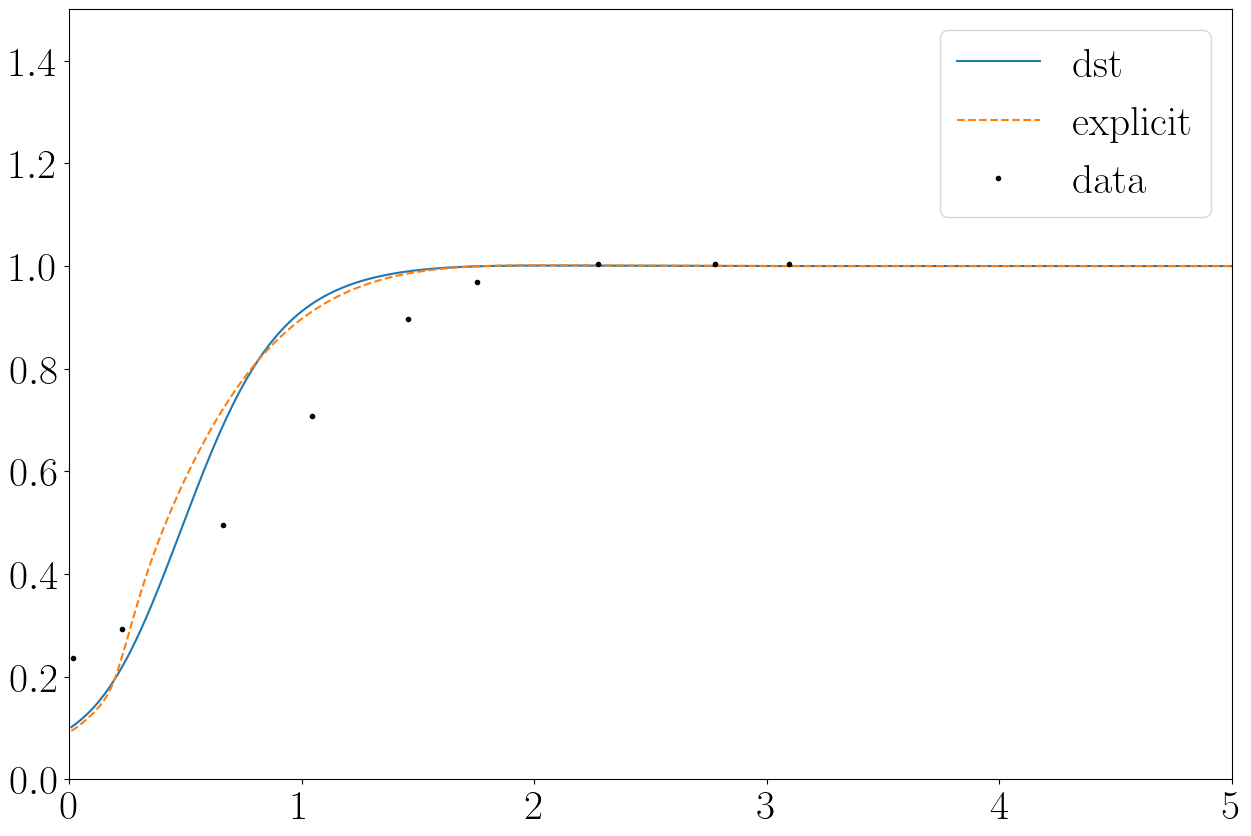

In [14]:
fig, ax = plt.subplots()
DD_data_rs1_t1 = np.array([[0.015915119363395226, 0.22208955223880597],
[0.16710875331564987, 0.2740298507462687 ],
[0.42572944297082227, 0.4298507462686567 ],
[0.7519893899204244, 0.6698507462686567 ],
[1.0145888594164456, 0.8202985074626866 ],
[1.3647214854111407, 0.9223880597014925 ],
[1.9456233421750664, 0.9779104477611941 ],
[2.944297082228117, 1.0011940298507462  ]]).T

DD_data_rs40_t8 = np.array([[0.09767441860465116, 0.002628120893561104 ],
[0.3697674418604651, 0.02759526938239159  ],
[0.5895348837209302, 0.16294349540078845  ],
[0.8093023255813954, 0.4231274638633377  ],
[1.0186046511627906, 0.6649145860709593  ],
[1.1651162790697673, 0.7936925098554534  ],
[1.3813953488372093, 0.9132720105124836  ],
[1.744186046511628, 0.9894875164257556  ],
[2.644186046511628, 1.0052562417871223  ]]).T

DD_data_rs1_t0p0625 = np.array([[0.015810276679841896, 0.2360060514372163],
[0.2292490118577075, 0.291981845688351   ],  
[0.6600790513833992, 0.4962178517397882  ],  
[1.0434782608695652, 0.708018154311649   ], 
[1.4584980237154148, 0.897125567322239   ],  
[1.7549407114624505, 0.9697428139183056  ], 
[2.276679841897233, 1.0030257186081695   ],
[2.7786561264822134, 1.0030257186081695  ], 
[3.0948616600790513, 1.0030257186081695  ]]).T

ax.plot(hnc1.r_array, h_r_DST+1,'-', label='dst')
ax.plot(hnc1.r_array, h_r_explicit+1,'--',label='explicit')
# ax.plot(DD_data_rs1_t1[0],DD_data_rs1_t1[1],'k.',label='data')
# ax.plot(DD_data_rs40_t8[0],DD_data_rs40_t8[1],'k.',label='data')
ax.plot(DD_data_rs1_t0p0625[0],DD_data_rs1_t0p0625[1],'k.',label='data')
ax.legend()
ax.set_xlim(0,5)
ax.set_ylim(0,1.5)